# Pyro Examples

In [1]:
import pandas as pd
import numpy as np
from orbit.lgt import LGT
from orbit.utils.plot import plot_predicted_data
from orbit.utils.plot import plot_predicted_components

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [3]:
DATA_FILE = "./data/iclaims_example.csv"

In [4]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

### Train / Test Split

In [5]:
df=raw_df.copy()
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [6]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.18397,0.72014,1.11967
1,2010-01-10,825891,1.18397,0.81490,1.17860
2,2010-01-17,659173,1.20338,0.73909,1.11967
3,2010-01-24,507651,1.16456,0.81490,1.10788
4,2010-01-31,538617,1.08693,0.77699,1.07253


## MAP Fit and Predict

In [7]:
lgt_map=LGT(
    response_col="claims",
    date_col="week",
    seasonality=52,
    seed=8888,
    inference_engine='pyro',
    infer_method='map',
    predict_method='map',
    auto_scale=False,
    is_multiplicative=True,
    verbose=True,
)

In [8]:
%%time
lgt_map.fit(df=train_df)

step    0 loss = 74.938
step  100 loss = -569.12
step  200 loss = -577.23
step  300 loss = -576.62
step  400 loss = -577.62
step  500 loss = -576.71
CPU times: user 57.9 s, sys: 784 ms, total: 58.7 s
Wall time: 59.3 s


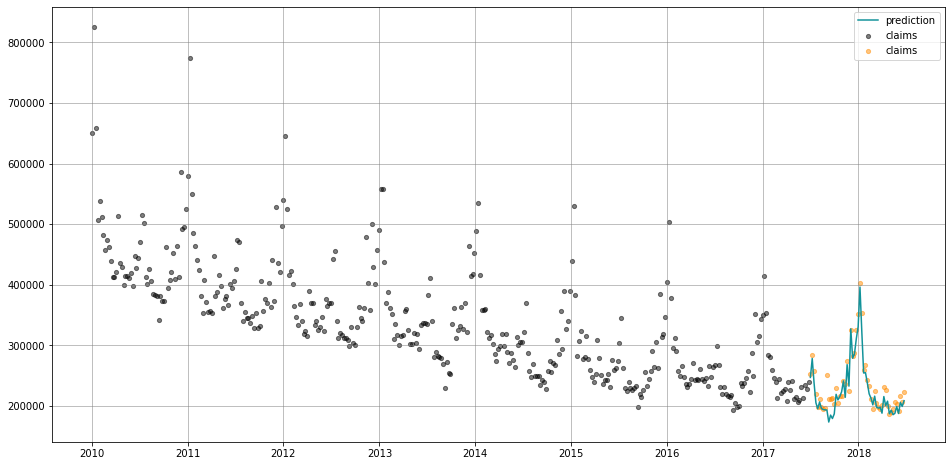

In [9]:
predicted_df = lgt_map.predict(df=test_df)
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_map.date_col, actual_col=lgt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## VI Fit and Predict

Pyro only support Variational Inference(SVI) for full sampling prediction.  Note that `pyro` takes advantage of parallel processing in `vi` and hence result in similar computation time compared to `map`.

In [10]:
lgt_vi = LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    num_warmup=4000, 
    num_sample=500,
    seed=8888,
    inference_engine='pyro',
    infer_method='vi',
    predict_method='full',
    n_bootstrap_draws=500,
    verbose=True,
)

In [11]:
%%time
lgt_vi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 166.72, scale = 0.10136
step  100 loss = -443.63, scale = 0.36164
step  200 loss = -447.02, scale = 0.34276
step  300 loss = -447.3, scale = 0.33369
step  400 loss = -445.76, scale = 0.35525
step  500 loss = -446.96, scale = 0.33369
CPU times: user 10min 3s, sys: 12.1 s, total: 10min 15s
Wall time: 1min 31s


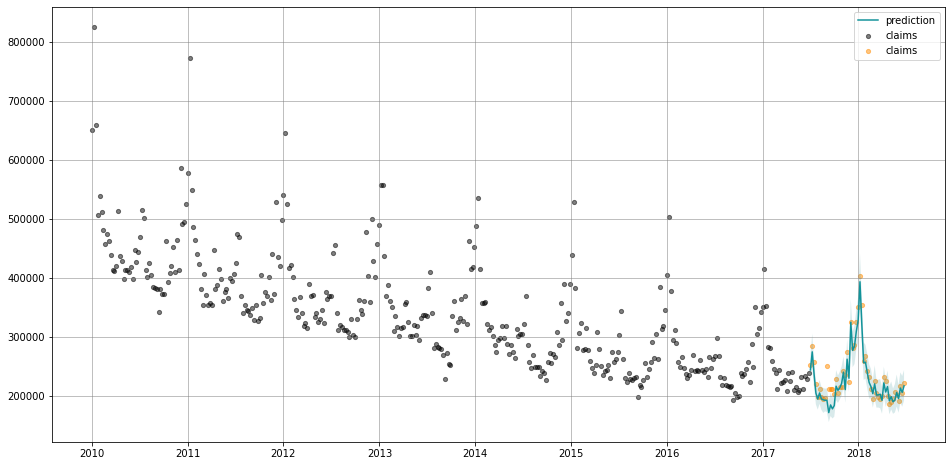

In [12]:
predicted_df = lgt_vi.predict(df=test_df)
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_vi.date_col, actual_col=lgt_vi.response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Fit with Regressors

### with MAP

In [13]:
lgt_reg_map=LGT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    regressor_sign=['=','='],
    date_col='week',
    seasonality=52,
    seed=8888,
    inference_engine='pyro',
    infer_method='map',
    predict_method='map',
    auto_scale=False,
    verbose=True,
)

In [14]:
%%time
lgt_reg_map.fit(df=train_df)

step    0 loss = 228.03
step  100 loss = -543.3
step  200 loss = -549.62
step  300 loss = -549.94
step  400 loss = -550.06
step  500 loss = -550.12
CPU times: user 4min 38s, sys: 3.47 s, total: 4min 41s
Wall time: 1min 11s


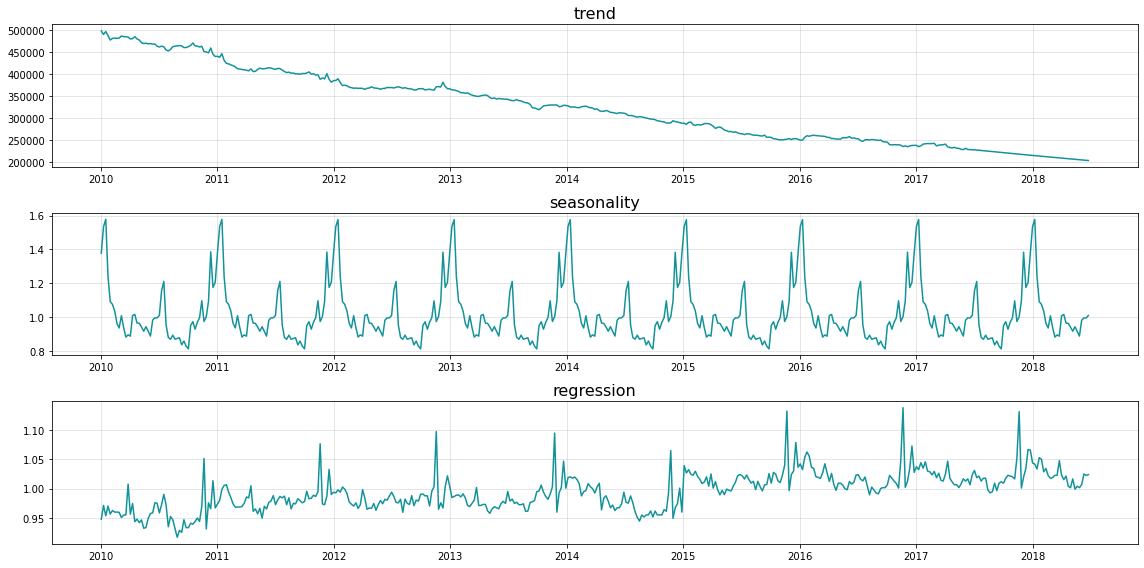

In [15]:
predicted_df = lgt_reg_map.predict(df=df,  decompose=True)
plot_predicted_components(predicted_df=predicted_df, date_col='week')

### with VI

In [16]:
lgt_reg_vi=LGT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    regressor_sign=['=','='],
    date_col='week',
    seasonality=52,
    seed=8888,
    inference_engine='pyro',
    infer_method='vi',
    predict_method='mean',
    verbose=True,
)

In [17]:
%%time
lgt_reg_vi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 313.09, scale = 0.10377
step  100 loss = -438.86, scale = 0.3585
step  200 loss = -442.51, scale = 0.30478
step  300 loss = -443.24, scale = 0.30624
step  400 loss = -442.86, scale = 0.30197
step  500 loss = -442.89, scale = 0.29483
CPU times: user 13min, sys: 14.7 s, total: 13min 15s
Wall time: 1min 57s


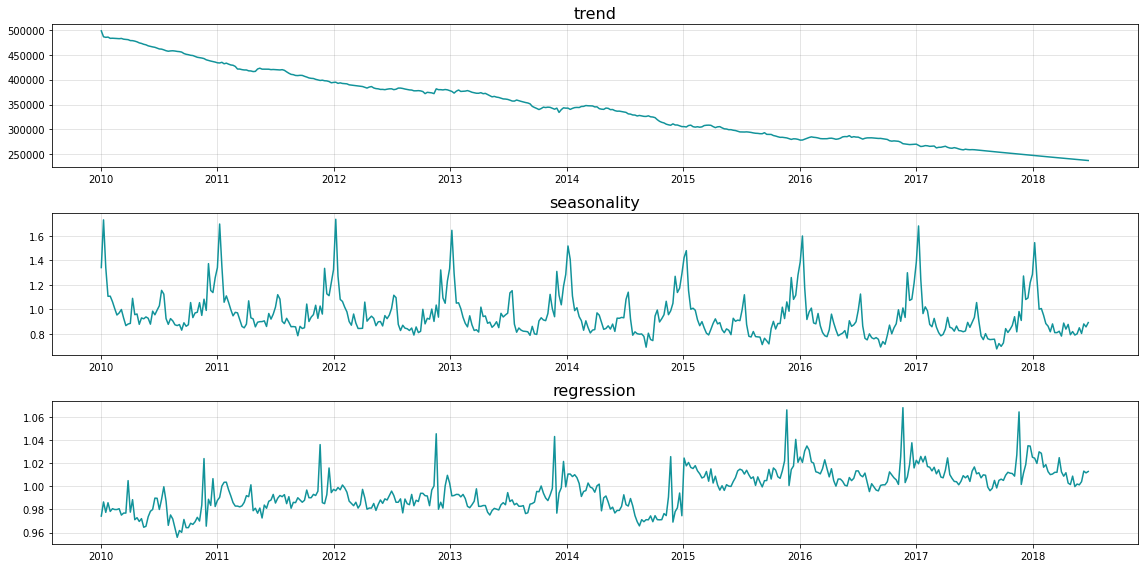

In [18]:
predicted_df = lgt_reg_vi.predict(df=df,  decompose=True)
plot_predicted_components(predicted_df=predicted_df, date_col='week')